In [1]:
import matplotlib.pyplot as plt
import numpy as np

# L96 provides the "real world", L96_eq1_xdot is the beginning of rhs of X tendency
from L96_model import L96, RK2, RK4, EulerFwd, L96_eq1_xdot

In [2]:
# Setting the seed gives us reproducible results
np.random.seed(13)

# Create a "real world" with K=8 and J=32
W = L96(8, 32, F=18)

# Run "real world" for 3 days to forget initial conditons
# (store=True save the final state as an initial condition for the next run)
W.run(0.05, 3.0, store=True);

# From here on we can use W.X as perfect initial conditions for a model
# and sample the real world using W.run(dt,T)

In [3]:
# X0 - initial conditions, dt - time increment, nt - number of forward steps to take
def GCMnoparam(X0, F, dt, nt):
    time, hist, X = (
        dt * np.arange(nt + 1),
        np.zeros((nt + 1, len(X0))) * np.nan,
        X0.copy(),
    )
    hist[0] = X

    for n in range(nt):
        X = X + dt * (L96_eq1_xdot(X, F))
        hist[n + 1], time[n + 1] = X, dt * (n + 1)
    return hist, time

In [4]:
# This GCM is unstable due to Euler forward time stepping scheme,
# so we integrate for not too long...
F, dt, T = 18, 0.01, 3.0
X, t = GCMnoparam(W.X, F, dt, int(T / dt))

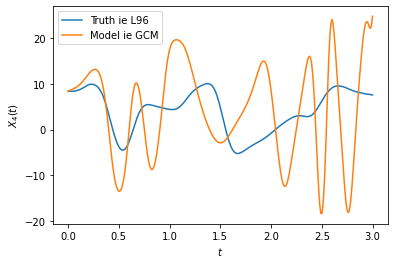

In [5]:
# ... and compare to the real world with the same time interval as "dt" used by the model
Xtrue, _, _ = W.run(dt, T)

plt.plot(t, Xtrue[:, 4], label="Truth ie L96")
plt.plot(t, X[:, 4], label="Model ie GCM")
plt.xlabel("$t$")
plt.ylabel("$X_4(t)$")
plt.legend();

In [6]:
# - a GCM class including a parameterization in rhs of equation for tendency
class GCM:
    def __init__(self, F, parameterization, time_stepping=EulerFwd):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F) - self.parameterization(param, X)

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [7]:
# As a first step, we illustrate introducing a polynomial parameterization to GCM
naive_parameterization = lambda param, X: np.polyval(param, X)
F, dt, T = 18, 0.01, 5.0
gcm = GCM(F, naive_parameterization)
X, t = gcm(W.X, dt, int(T / dt), param=[0.85439536, 1.75218026])

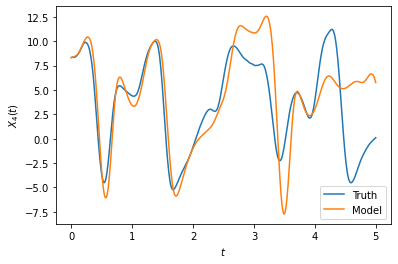

In [8]:
# Comparing model and true trajectories.

# This samples the real world with the same time interval as "dt" used by the model
Xtrue, _, _ = W.run(dt, T)

plt.plot(t, Xtrue[:, 4], label="Truth")
plt.plot(t, X[:, 4], label="Model")
plt.xlabel("$t$")
plt.ylabel("$X_4(t)$")
plt.legend();

In [9]:
# - randomising the initial Ys
np.random.seed(13)

# Duplicating L96 to create perturbed versions that include random perturbations in Y
Wp1 = W.copy()
Yp1 = W.Y.std() * np.random.rand(Wp1.Y.size)
Wp1.set_state(W.X, Yp1)

Wp2 = W.copy()
Yp2 = W.Y + 0.0001 * np.random.rand(Wp2.Y.size)
Wp2.set_state(W.X, Yp2)

L96: K=8 J=32 F=18 h=1 b=10 c=10 dt=0.001

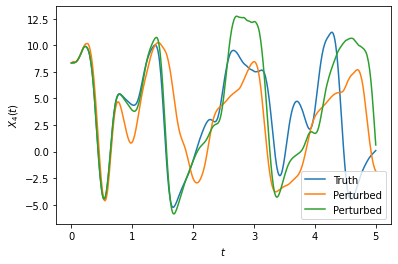

In [10]:
# Running L96 and perturbed versions to compare results
Xtrue, _, _ = W.run(dt, T)
Xpert1, _, _ = Wp1.run(dt, T)
Xpert2, _, _ = Wp2.run(dt, T)
plt.plot(t, Xtrue[:, 4], label="Truth")
plt.plot(t, Xpert1[:, 4], label="Perturbed")
plt.plot(t, Xpert2[:, 4], label="Perturbed")
plt.xlabel("$t$")
plt.ylabel("$X_4(t)$")
plt.legend();

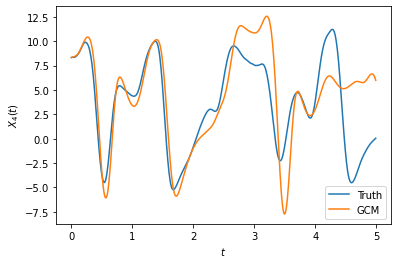

In [11]:
# - Let's define again our GCM
F, dt, T = 18, 0.01, 100.0
gcm = GCM(F, naive_parameterization)
Xgcm, t = gcm(W.X, dt, int(T / dt), param=[0.85439536, 1.75218026])

# - ... the true state
Xtrue, _, _ = W.run(dt, T)

## and plot the results
plt.plot(t[:500], Xtrue[:500, 4], label="Truth")
plt.plot(t[:500], Xgcm[:500, 4], label="GCM")
plt.xlabel("$t$")
plt.ylabel("$X_4(t)$")
plt.legend();

In [12]:
# - A first simple choice :
def pointwise(X1, X2, L=1.0):  # computed over some window t<L.
    D = (X1 - X2)[np.where(t < L)]
    return np.sqrt(D**2).mean(axis=0)

In [13]:
measure_dist = lambda l: pointwise(Xtrue, Xgcm, L=l)
dist = np.array([measure_dist(l) for l in t])

/tmp/ipykernel_2670/251060749.py:4: RuntimeWarning: Mean of empty slice.
  return np.sqrt(D**2).mean(axis=0)
/usr/share/miniconda/envs/L96M2lines/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


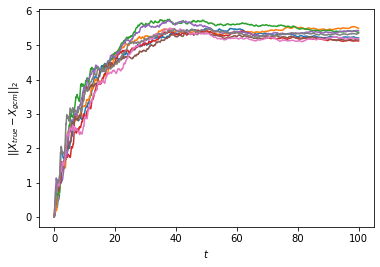

In [14]:
# - plotting how this distance grows with the length of the window
#  for all the components of X
plt.plot(t, dist)
plt.xlabel("$t$")
plt.ylabel("$||X_{true}-X_{gcm}||_2$")
plt.show()

In [15]:
# - mean state metric :
def dist_mean(X1, X2, L=1.0):
    _X1 = X1[np.where(t < L)]
    _X2 = X2[np.where(t < L)]
    return np.sqrt((_X1.mean(axis=0) - _X2.mean(axis=0)) ** 2)

In [16]:
measure_dist = lambda l: dist_mean(Xtrue, Xgcm, L=l)
dist = np.array([measure_dist(l) for l in t])

/tmp/ipykernel_2670/4255757646.py:5: RuntimeWarning: Mean of empty slice.
  return np.sqrt((_X1.mean(axis=0) - _X2.mean(axis=0)) ** 2)


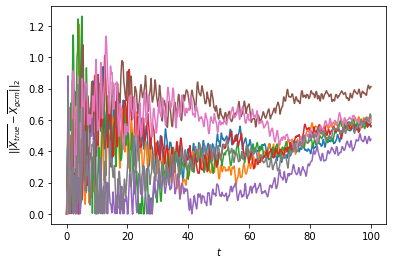

In [17]:
# - plotting how this distance grows with the length of the window
#  for all the components of X
plt.plot(t, dist)
plt.xlabel("$t$")
plt.ylabel("$||\overline{X_{true}}-\overline{X_{gcm}}||_2$")
plt.show()

In [18]:
def norm_initial_tendency(X1, X2):
    T1 = X1[1, :] - X1[0, :]
    T2 = X2[1, :] - X2[0, :]
    return np.sqrt((T1 - T2) ** 2).mean(axis=0)

In [19]:
F, dt, T = 18, 0.01, 0.01


# - Let's define again the true state
Xtrue, _, _ = W.run(dt, T)

#  and an ensemble of trajectories :

gcm = GCM(F, naive_parameterization)

n = 100

_p1 = np.linspace(-20, 20, n + 1)
_p2 = np.linspace(-20, 20, n + 1)
xp1, yp2 = np.meshgrid(_p1, _p2)

score = np.zeros((n + 1, n + 1))

for i, p1 in enumerate(_p1):
    for j, p2 in enumerate(_p2):
        Xgcm, t = gcm(W.X, dt, int(T / dt), param=[p1, p2])
        score[i, j] = norm_initial_tendency(Xtrue, Xgcm)

Text(0.5, 1.0, 'Score')

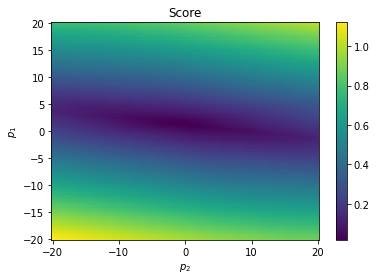

In [20]:
plt.pcolormesh(xp1, yp2, score)
plt.colorbar()
plt.xlabel("$p_2$")
plt.ylabel("$p_1$")
plt.title("Score")

In [21]:
# - Generic GCM parameters
F, dt, T = 18, 0.01, 20.0
X0 = W.X
parameterization = naive_parameterization
params = [0.85439536, 1.75218026]

# - sampling real world over a longer period of time
Xtrue, _, _ = W.run(dt, T)

In [22]:
max_relative_error = 0.01
Fs = F + max_relative_error * (np.random.rand(40) - 0.5)  # array of perturbed forcings

In [23]:
GCMs = [GCM(Fp, parameterization) for Fp in Fs]
Xs = []  # list of trajectories for individual perturbed forcings
for gcm in GCMs:
    X, t = gcm(X0, dt, int(T / dt), param=params)
    Xs.append(X)

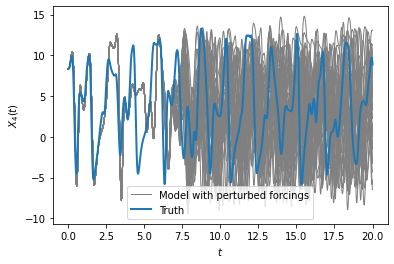

In [24]:
plt.plot(t, Xs[0][:, 4], label="Model with perturbed forcings", color="grey", lw=1)
for X in Xs[1:]:
    plt.plot(t, X[:, 4], color="grey", lw=1)
plt.plot(t, Xtrue[:, 4], label="Truth", lw=2)
plt.xlabel("$t$")
plt.ylabel("$X_4(t)$")
plt.legend();

In [25]:
relative_error = 0.01
X0s = X0 + max_relative_error * (
    np.random.rand(50, 8) - 0.5
)  # array of perturbed initial conditions
gcm = GCM(F, parameterization)
Xs = []  # list of trajectories for individual preturbed initial conditions
for X0 in X0s:
    X, t = gcm(X0, dt, int(T / dt), param=params)
    Xs.append(X)

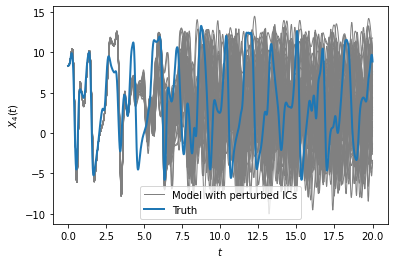

In [26]:
plt.plot(t, Xs[0][:, 4], label="Model with perturbed ICs", color="grey", lw=1)
for X in Xs[1:]:
    plt.plot(t, X[:, 4], color="grey", lw=1)
plt.plot(t, Xtrue[:, 4], label="Truth", lw=2)
plt.xlabel("$t$")
plt.ylabel("$X_4(t)$")
plt.legend();

In [27]:
F, dt, T = 18, 0.01, 10.0
X0 = W.X
#
euler_GCM = GCM(F, naive_parameterization, time_stepping=EulerFwd)
rk2_GCM = GCM(F, naive_parameterization, time_stepping=RK2)
rk4_GCM = GCM(F, naive_parameterization, time_stepping=RK4)
#
euler_X, t = euler_GCM(X0, dt, int(T / dt), param=[0.85439536, 1.75218026])
rk2_X, _ = rk2_GCM(X0, dt, int(T / dt), param=[0.85439536, 1.75218026])
rk4_X, _ = rk4_GCM(X0, dt, int(T / dt), param=[0.85439536, 1.75218026])

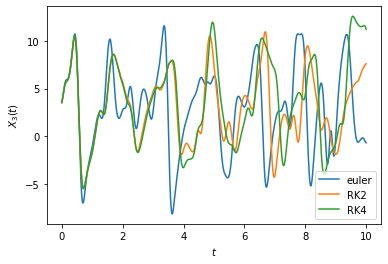

In [28]:
plt.plot(t, euler_X[:, 3], label="euler")
plt.plot(t, rk2_X[:, 3], label="RK2")
plt.plot(t, rk4_X[:, 3], label="RK4")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$X_3(t)$")
plt.show()